### Checking Fluoresecnce from Nanodiamonds under a 3D printed microscope. 
The code herein is designed to load up a .tiff file recorded from one fo Gemma's 3D printed microscopes. 

The .tiff file is plotted on a 2D heat map. 

From here, the Skimage package is used to located the bright nanodiamond clusters in the image. 

Once the bright spots are located the image, I need some way of recording/extracting the image information. for this spot. 
From here, the second image will be loaded in and then, using the same/similar regions of the sample (dependednt on drift) the nanodiamonds will be located and the brightness of the spots in the image will be compared. 

In this first pass, I will only ever be comparing 2 images, which show the fluorescence of the nanodiamond with microwaves applied both on and off resonance. 

In [1]:
import matplotlib.pyplot as plot 
import numpy as np
import pandas as pd 
import scipy 
import os 
import skimage.feature as si
from matplotlib.collections import PatchCollection
import tifffile

In [2]:
def load_image(file_name):
    '''Takes the image location and loads the data into a 
    tifffile array which is then turned into a numpy array '''
    image_array = tifffile.imread(file_name)
   
    ima_array_np = np.array(image_array)
    
    
    return(ima_array_np)

In [3]:
def set_plot_params():
    '''formats the plot parameters''' 
    plot.rcParams.update({'font.size' : 16})
    plot.rcParams.update({'figure.figsize' :[16, 12]})

In [4]:
def get_scalebar(x_scan, voxel_size, ax):
    '''# defines the length of the scale bar and its caption.
    Not used yet'''
    
    scale_bar_pixel_length = 0.1* len(x_scan)
    scale_bar_si_length = round(scale_bar_pixel_length*voxel_size, 1)
    
    #Generate scale bar
    bar = AnchoredSizeBar(ax.transData, scale_bar_pixel_length, 
                          str(scale_bar_si_length) + r'$\mu$m', 
                          4, size_vertical = 1, pad = 0.25)
   # Add scalebar to image
    ax.add_artist(bar)
    
    return(int(scale_bar_pixel_length), scale_bar_si_length)

In [5]:
def remove_background(image):
    '''Here, I use a crude method of cleaning up each frame in the 3D image stack. 
    Every pixel value in the image which is lower than twice the mean pixel value 
    is set to 0. This helps to remove some of the weird specal that is in the camera 
    image. 
    '''
    image_cleaned = np.empty(image.shape)
    # Loop repeats for the number of 2D images in 
    # image stack.
    for i in range(image.shape[0]):
        x = image[i,:,:] # Current 2D dataset.
        background = np.mean(x) # Find the mean pixel value in image. 
        
        # Clean up the image and remove most of the background noise
        # Possibly lose some of the dimmer NDs here. 
        
        x[x < background*2] = 0 # set pixel values < 2*background to 0
        image_cleaned[i, :, :] = x # Generate the "clean image" array
    
    return(image_cleaned)

In [6]:
def find_NDs(image_frame, min_dis, num_NDs):
    '''Uses the skimage package to locate the local maxima of an image. '''
    
    # Find the NDs/ bright spots in the image.  
    nd_locations = si.peak_local_max(image_frame, min_distance = min_dis, exclude_border = True, num_peaks = num_NDs)
    # create new local variables
    nds = []
    counts = []
    x_prev, y_prev = [0,0]
    
    # I then sort the data in so that only those data points that correspond 
    # to NDs (or remaining bright spots from laser). 
    # I also stop repeats of NDs that have been seen in the in the image stacks. 
    for i in range(len(nd_locations)):
        x, y = nd_locations[i]
        # if bright spot is a hot pixel, ignore it. Otherwise complete the following. 
        if np.sum(image_frame[x-1:x+1, y-1:y+1]) != image_frame[x,y]:
            # If the bright spot is a repeat of previous point, ignore. 
            if x == x_prev-1 or x == x_prev + 1 or y == y_prev + 1 or y == y_prev - 1:
                continue
            else:
                nds.append([x, y])
                counts.append(image_frame[x, y])
                x_prev = x
                y_prev = y
            
    counts = np.array(counts)
    return(nds, counts)

In [7]:
def find_local_ND(image_frame, nds, radius):
    '''Here I will search for the brightest spot in a pre-defined square 
    surrounding the NDs that have been identified from the first frame 
    (off-resonant image).'''
    
    print(image_frame.shape)
    nds_2 = []
    counts = []
    
    for i in range(len(nds)):
        # Find the limits of the image to be scanned for a ND. 
        if nds[i][0]-radius < 0: 
            x_low_limit = 0
        else: 
            x_low_limit = nds[i][0] - radius
            
        if nds[i][0]+radius > image_frame.shape[0]:
            x_high_limit = image_frame.shape[0]
        else: 
            x_high_limit = nds[i][0] + radius
            
        if nds[i][1]-radius < 0: 
            y_low_limit = 0
        else: 
            y_low_limit = nds[i][1]-radius
            
        if nds[i][1]+radius > image_frame.shape[1]:
            y_high_limit = image_frame.shape[1]
        else: 
            y_high_limit = nds[i][1]+radius
        
        # Find the NDs/ bright spots in the bounded region.
        cropped_image = image_frame[x_low_limit:x_high_limit, y_low_limit:y_high_limit]
        nd_locations = si.peak_local_max(cropped_image, min_distance = int(radius/2), exclude_border = True, num_peaks = 1)
        
        x = nd_locations[0][0] + x_low_limit
        y = nd_locations[0][0] + y_low_limit
        
        counts.append(nd_locations)
        nds_2.append([x,y])
    
    return(nds_2, counts)

In [8]:
def plot_roi(nd_locs, ax, color, radius):
    '''I have grabbed/ammended this function from: 
     https://stackoverflow.com/questions/51672327/skimage-peak-local-max-finds-multiple-spots-in-close-proximity-due-to-image-impu
     I am sure that this isn't an issue for copyright/IP or anything, but better to be safe.''' 

    # This function plots all of the regions of interest onto the heatmap. 
    patches = []
    a = 1
    for nd in nd_locs:
        y, x = nd
        c = plot.Rectangle((x-radius/2,y-radius/2), radius, radius, ec = color)
        ax.annotate('ND ' + str(a), xy = [x+50, y-50], color = color)
        patches.append(c)
        a += 1
        
    ax.add_collection(PatchCollection(patches, facecolors = "None", edgecolors = color, alpha = 0.5, linewidths = 3))

In [9]:
def get_nd_squares_intensity(radius, image, nds):
    '''This function is used to find the sum of all the pixels 
    in the region around the point of maximum fluoresences for each 
    of the NDs in the image as outlined by the "plot_ROI" method. 
    This value is found for each of the images in the image stack, the ROI positions are  
    constant for all images in the stack and are generated from the first image in the stack. '''
    
    square_len = int(radius/2)

    ND_square_intensity = np.empty([image.shape[0], len(nds)])
    for i in range(image.shape[0]):
        for j in range(len(nds)):
            ND_square_intensity[i, j] = np.sum(image[i, nds[j][0]-square_len:nds[j][0]+square_len, nds[j][1]-square_len:nds[j][1]+square_len])
        
    mean_ND_Square_intensity = np.mean(ND_square_intensity, axis = 0)
    
    return(mean_ND_Square_intensity)    

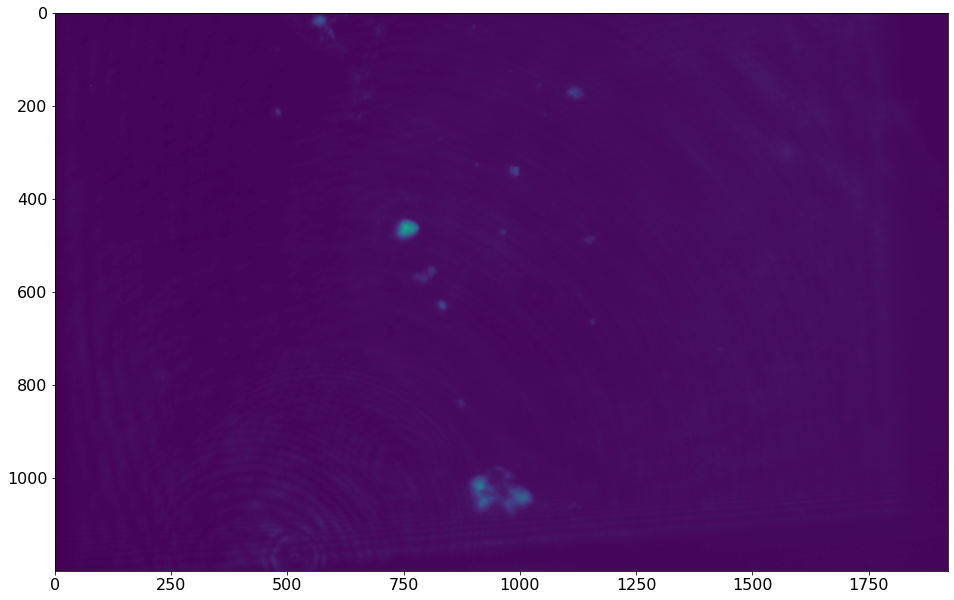

In [114]:
# Get the folder location for the data. 
folder = 'I:\\Science\\Physics-Nanobiophotonics\\Group\\User Data\\ODMR\\3D printed odmr\\20210322\\'
test = 'Test14'
file = '2.800ghz'

# make plots readable for humans. 
set_plot_params()

# Get the first set of image data. 
image_data = load_image(folder + test + '\\' + file + '.tif')

# Plot raw image to show the terrible state of affairs. 
t = plot.imshow(image_data[0,:,:])

# Remove most of the background from each frame in stack 
image_to_clean = load_image(folder + test + '\\' + file + '.tif')
image_cleaned = remove_background(image_to_clean)



# Get the second set of image data. 
file_2 = '2.866ghz'
image_data_2 = load_image(folder + test + '\\' + file_2 + '.tif')

# Remove most of the background from each frame in stack 
image_to_clean_2 = load_image(folder + test + '\\' + file_2 + '.tif')
image_cleaned_2 =  remove_background(image_to_clean_2)

(1200, 1920)


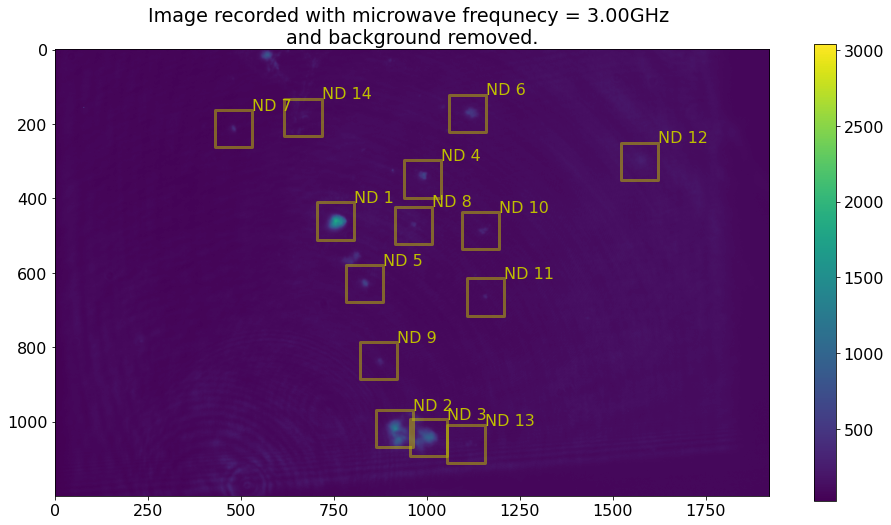

In [115]:
fig, ax = plot.subplots()
ax.set_title('Image recorded with microwave frequnecy = 3.00GHz \nand background removed.')
h = ax.imshow(image_data[0,:,:])
fig.colorbar(h, ax=ax, shrink =0.7)

# Find the fluorescent points in the image.
radius = 100
num_of_nds = 50
# find the ND location, and the maximum counts from the fluorescent points
#nds, counts = find_NDs(image_cleaned[0,:,:], radius, num_of_nds)
nds, counts = find_local_ND(image_cleaned[0,:,:], nd_poisitons, radius)


# plot the regions of interest (fluorescent points) as yellow circles. 
color = 'y'
plot_roi(nds, ax, color, radius)

(1200, 1920)


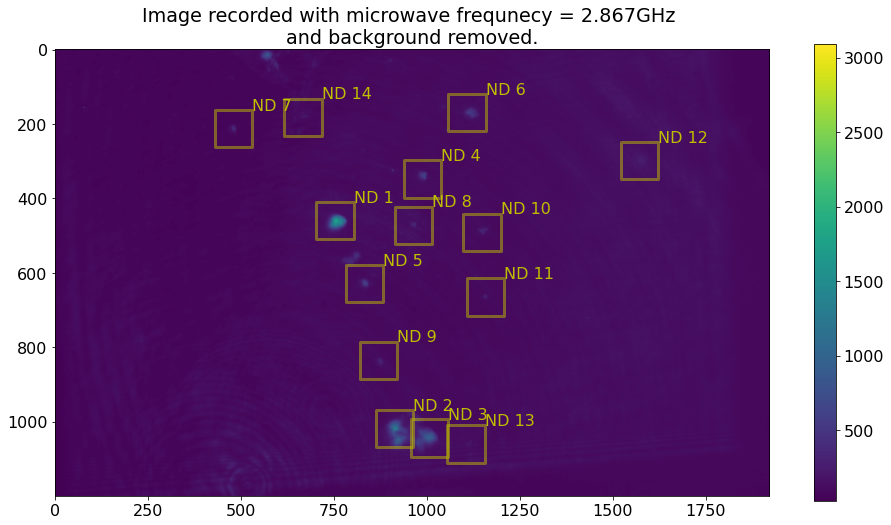

In [116]:
fig2, ax2 = plot.subplots()
ax2.set_title('Image recorded with microwave frequnecy = 2.867GHz \nand background removed.')
k = ax2.imshow(image_data_2[0,:,:])
fig.colorbar(k, ax=ax2, shrink =0.7)

nds_2, counts_2 = find_local_ND(image_cleaned_2[0,:,:], nds, radius)
plot_roi(nds_2, ax2, color, radius)

In [117]:
# Find the change in the fluorescence intensity from each ND.

mean_ND_intesities_Image_1 = get_nd_squares_intensity(radius, image_data, nds[0:len(nds_2)])

mean_ND_intesities_Image_2 = get_nd_squares_intensity(radius, image_data_2, nds[0:len(nds_2)])

contrast = (1 - (mean_ND_intesities_Image_2/mean_ND_intesities_Image_1))*100

print('ND 1 Contrast = ' + str(round(contrast[0], 3)) + ' %\n')
print('ND 2 Contrast = ' + str(round(contrast[1], 3)) + ' %\n')
print('ND 3 Contrast = ' + str(round(contrast[2], 3)) + ' %\n')
print('ND 4 Contrast = ' + str(round(contrast[3], 3)) + ' %\n')
print('ND 5 Contrast = ' + str(round(contrast[4], 3)) + ' %\n')
print('ND 6 Contrast = ' + str(round(contrast[5], 3)) + ' %\n')
print('ND 7 Contrast = ' + str(round(contrast[6], 3)) + ' %\n')
print('ND 8 Contrast = ' + str(round(contrast[7], 3)) + ' %\n')
print('ND 9 Contrast = ' + str(round(contrast[8], 3)) + ' %\n')
print('ND 10 Contrast = ' + str(round(contrast[9], 3)) + ' %\n')
print('ND 11 Contrast = ' + str(round(contrast[10], 3)) + ' %\n')
print('ND 12 Contrast = ' + str(round(contrast[11], 3)) + ' %\n')
print('ND 13 Contrast = ' + str(round(contrast[12], 3)) + ' %\n')
print('ND 14 Contrast = ' + str(round(contrast[13], 3)) + ' %\n')

In [118]:
headers = ['Number of scans off res', 'Number of scans on res', 'ND1 contrast (%)', 
           'ND2 contrast (%)', 'ND3 contrast (%)', 'ND4 contrast (%)', 'ND5 contrast (%)', 
           'ND6 contrast (%)', 'ND7 contrast (%)', 'ND8 contrast (%)', 'ND9 contrast (%)', 
           'ND10 contrast (%)', 'ND11 contrast (%)', 'ND12 contrast (%)', 'ND13 contrast (%)', 'ND14 contrast (%)']

data = {test:[int(image_data.shape[0]), int(image_data_2.shape[0]), contrast[0], contrast[1], contrast[2], contrast[3], 
              contrast[4], contrast[5], contrast[6], contrast[7], contrast[8], contrast[9],
             contrast[10], contrast[11], contrast[12], contrast[13]]}

In [119]:
new_test_data = pd.DataFrame(data, index = headers)
counts_data_frame = pd.concat([counts_data_frame, new_test_data], axis=1)

In [120]:
print(counts_data_frame)

                             Test6      Test7      Test8      Test9  \
Number of scans off res  51.000000  51.000000  52.000000  52.000000   
Number of scans on res   51.000000  52.000000  52.000000  51.000000   
ND1 contrast (%)          0.436238   0.779718   1.518305   0.760550   
ND2 contrast (%)          1.813830   1.556395   2.638627  -0.200370   
ND3 contrast (%)          2.526264   1.710943   1.339501  -0.751564   
ND4 contrast (%)          0.302760  -0.147113   0.585658   0.116245   
ND5 contrast (%)         -0.755282   0.956350  -0.062311  -0.190637   
ND6 contrast (%)          0.781907   0.349522  -0.055203   0.184575   
ND7 contrast (%)         -0.257517   0.142582   1.389719  -0.067094   
ND8 contrast (%)         -0.241489   1.456087  -0.048215   0.473615   
ND9 contrast (%)         -0.444797   1.032930   0.182370   0.062574   
ND10 contrast (%)         0.407780   1.240342   0.136673   0.586868   
ND11 contrast (%)        -0.247765  -0.201208   0.071722  -0.025505   
ND12 c

In [131]:
save_folder = 'I:\\Science\\Physics-Nanobiophotonics\\Group\\User Data Analysis\\Ryans Data (2018-2021)\\3D Printed ODMR'
date = '20210322'
file = 'ND_Contrast_Data'
#np.savetxt(save_folder + '\\' + date + '\\' + date + '_' + file + '.txt', 
#           counts_data_frame, fmt = '%f', delimiter="\t") 

counts_data_frame.to_csv(save_folder + '\\' + date + '\\' + date + '_' + file + '.txt', sep = '\t')

In [36]:
nd_poisitons = nds

In [64]:
print(test)

Test7


counts_data_frame = pd.DataFrame(data, index = headers)
